In [ ]:
# !unzip /content/gdrive/MyDrive/ssd.zip -d /content/gdrive/MyDrive

**Resources**

1. https://pysource.com/2020/04/02/train-yolo-to-detect-a-custom-object-online-with-free-gpu/

2. https://www.youtube.com/watch?v=_FNfRtXEbr4&t=2s

3. https://timebutt.github.io/static/how-to-train-yolov2-to-detect-custom-objects/

4. https://colab.research.google.com/drive/1mzL6WyY9BRx4xX476eQdhKDnd_eixBlG#scrollTo=NjKzw2TvZrOQ

5. https://medium.com/analytics-vidhya/train-a-custom-yolov4-object-detector-using-google-colab-61a659d4868#d4cc

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Thu Jul  7 05:51:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Connect google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pwd

/content


Go to the yolo directory

In [ ]:
cd /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash

/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash


**1) Clone the Darknet**



In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15494, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15494 (delta 0), reused 2 (delta 0), pack-reused 15490
Receiving objects: 100% (15494/15494), 14.11 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (10408/10408), done.
Checking out files: 100% (2057/2057), done.


**2) Compile Darknet using Nvidia GPU(Only works in NVIDIA GPU)**






In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
     

**3) Configure Darknet network for training YOLO V4-tiny**

**It will copy the desired config file to the same path with name yolov4_training**

In [ ]:
pwd

'/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet'

In [ ]:
!cp cfg/yolov4-tiny.cfg cfg/yolov4_training.cfg

Number of filters = (no of classes + 5)*3 (filter which is just above the classes)


max_batches = number of classes * 2000
steps = 80%max_batches, 90%max_batches

classes = no of classes you have

(Have to change these 3 times in the config file) 

**Navigate to darknet folder**

In [ ]:
cd /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet

/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet


**Make a test.txt, train.txt. classnamefile**

In [ ]:
!echo "fire\n smoke\n" > data/obj.names
!echo -e 'classes= 2\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = backup' > data/obj.data
!mkdir data/obj #dataset folder

Go to the darknet/data directory and check obj.names, if it has your classes.

data/obj.names, if it has the path of saved weights

In [ ]:
# Download weights darknet model 53 (Conv layers)
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-10-04 04:18:47--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  54.5MB/s    in 2.8s    

2022-10-04 04:18:50 (54.5 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**4) Extract Images**

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "data/obj" on Google Drive

In [ ]:
!unzip /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/face_mask.v1i.darknet.zip -d /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj

Archive:  /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/face_mask.v1i.darknet.zip
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/README.dataset.txt  
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/README.roboflow.txt  
   creating: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/_darknet.labels  
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/mask7aa514d0-38a6-11ed-a935-697ba1a2207b_jpg.rf.d74ddf1b43918af5c433e8c00610bcfa.jpg  
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/mask7aa514d0-38a6-11ed-a935-697ba1a2207b_jpg.rf.d74ddf1b43918af5c433e8c00610bcfa.txt  
 extracting: /content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/mask7b0e286c-38a6-11ed-a935-697ba1a2207b_jpg.rf.530bc5995b1d26049e10b9f089b6d

**5. Training Data preparation** 

In [ ]:
# import glob
# import os
# import re

# txt_file_paths = glob.glob(r"data/obj/ok/train/*.txt")
# for i, file_path in enumerate(txt_file_paths):
#     # get image size
#     with open(file_path, "r") as f_o:
#         lines = f_o.readlines()

#         text_converted = []
#         for line in lines:
#             print(line)
#             numbers = re.findall("[0-9.]+", line)
#             print(numbers)
#             if numbers:

#                 # Define coordinates
#                 text = "{} {} {} {} {}".format(0, numbers[1], numbers[2], numbers[3], numbers[4])
#                 text_converted.append(text)
#                 print(i, file_path)
#                 print(text)
#         # Write file
#         with open(file_path, 'w') as fp:
#             for item in text_converted:
#                 fp.writelines("%s\n" % item)

Making the train.txt with path of all the images in the training set


In [ ]:
pwd

'/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet'

In [ ]:
import os
images_list = []
for img in os.listdir('/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/train'):
  if img.lower().endswith(('.png', '.jpg', '.jpeg')):
    img = '/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/train/' + img
    images_list.append(img)

#Create training.txt file
file = open("/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

In [ ]:
len(images_list)

519

**list of all testing images** 

Making the train.txt with path of all the images in the testing set


In [ ]:
import os
images_list = []
for img in os.listdir('/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test'):
  if img.lower().endswith(('.png', '.jpg', '.jpeg')):
    img = '/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/test/' + img
    images_list.append(img)

#Create training.txt file
file = open("/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/test.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

len(images_list)

93

**7. Start the training**
**(Weights will be saved in darknet/backup directory)**

In [ ]:
pwd

'/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet'

In [ ]:
# cd darknet

In [ ]:
!chmod +x darknet

In [ ]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov4_training.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
]2;3169/4000: loss=0.2 hours left=0.2
 3169: 0.189662, 0.156154 avg loss, 0.002610 rate, 0.543034 seconds, 202816 images, 0.169033 hours left
Loaded: 0.119289 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.825073), count: 42, class_loss = 0.098368, iou_loss = 0.445183, total_loss = 0.543552 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.786988), count: 59, class_loss = 0.270387, iou_loss = 0.998217, total_loss = 1.268604 
 total_bbox = 313663, rewritten_bbox = 0.000000 % 
]2;3170/4000: loss=0.2 hours left=0.2
 3170: 0.184590, 0.158997 avg loss, 0.002610 rate, 0.541374 seconds, 202880 images, 0.168757 hours left
Loaded: 0.142146 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.816814), count: 30, class_loss = 0.071636, i

**Check the Performance of the model**

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4_training.cfg backup/yolov4_training_last.weights -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104

**8. Check the Inference**

In [ ]:
# %cd cfg
# !sed -i 's/batch=64/batch=1/' yolov4_training.cfg
# !sed -i 's/subdivisions=16/subdivisions=1/' yolov4_training.cfg
# %cd ..

/content/gdrive/MyDrive/yolo/darknet/cfg
/content/gdrive/MyDrive/yolo/darknet


In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()



In [ ]:
import cv2
path = '/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/face_mask/Test/maskb39002d6-38a7-11ed-a8e6-c1b2999decca.jpg'
image = cv2.imread(path)
height, width = image.shape[:2]
resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
resized_image.shape


(1440, 1920, 3)

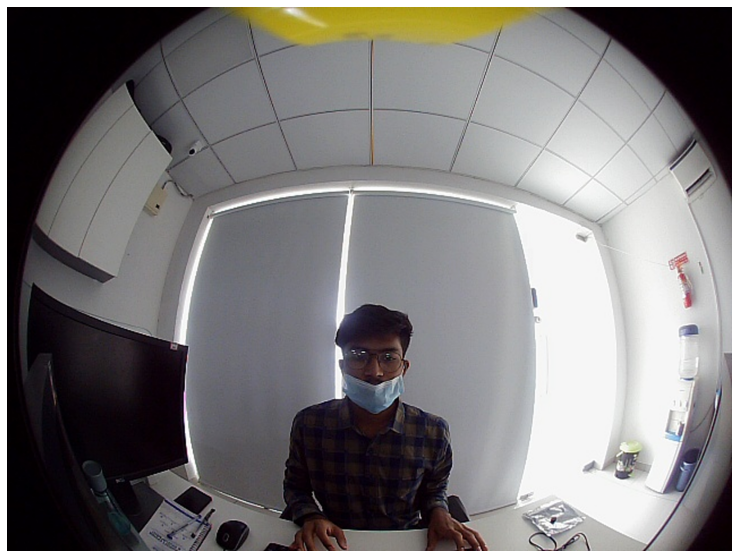

In [ ]:
imShow('/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/face_mask/Test/maskb39002d6-38a7-11ed-a8e6-c1b2999decca.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104

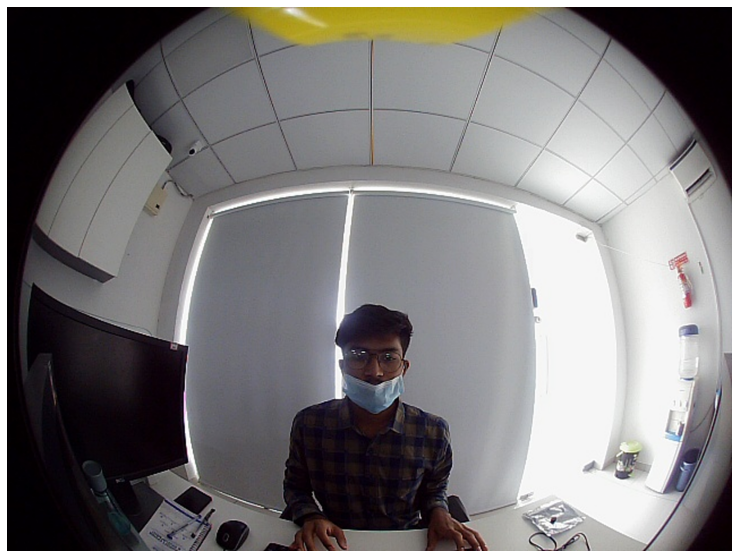

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4_training.cfg backup/yolov4_training_last.weights 'data/obj/face_mask/Test/maskb40745a8-38a7-11ed-a8e6-c1b2999decca.jpg' -thresh 0.10
imShow('/content/gdrive/MyDrive/yolo_pipeline/yolo_handwash/darknet/data/obj/face_mask/Test/maskb39002d6-38a7-11ed-a8e6-c1b2999decca.jpg')

Performance

In [ ]:
# import glob
# for i in glob.glob('data/obj/data/test/*.jpg'):
#   a = i
#   print(a)
#   # !./darknet detector test data/obj.data cfg/yolov4_training.cfg backup/yolov4_training_last.weights a -thresh 0.10


**Inference on Video**

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_best.weights -dont_show /mydrive/mask_test_videos/test1.mp4 -thresh 0.5 -i 0 -out_filename /mydrive/mask_test_videos/results1.avi

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1   

**Inference on Webcam**

In [ ]:
# # Code from theAIGuysCode Github (https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/yolov4_webcam.ipynb)
# # Adjusted for my custom YOLOv4 trained weights, config and obj.data files

# # import dependencies
# from IPython.display import display, Javascript, Image
# from google.colab.output import eval_js
# from google.colab.patches import cv2_imshow
# from base64 import b64decode, b64encode
# import cv2
# import numpy as np
# import PIL
# import io
# import html
# import time
# import matplotlib.pyplot as plt
# %matplotlib inline


# # import darknet functions to perform object detections
# from darknet import *
# # load in our YOLOv4 architecture network
# network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/obj.data", "/mydrive/yolov4/training/yolov4-custom_best.weights")
# width = network_width(network)
# height = network_height(network)

# # darknet helper function to run detection on image
# def darknet_helper(img, width, height):
#   darknet_image = make_image(width, height, 3)
#   img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   img_resized = cv2.resize(img_rgb, (width, height),
#                               interpolation=cv2.INTER_LINEAR)

#   # get image ratios to convert bounding boxes to proper size
#   img_height, img_width, _ = img.shape
#   width_ratio = img_width/width
#   height_ratio = img_height/height

#   # run model on darknet style image to get detections
#   copy_image_from_bytes(darknet_image, img_resized.tobytes())
#   detections = detect_image(network, class_names, darknet_image)
#   free_image(darknet_image)
#   return detections, width_ratio, height_ratio

# # function to convert the JavaScript object into an OpenCV image
# def js_to_image(js_reply):
#   """
#   Params:
#           js_reply: JavaScript object containing image from webcam
#   Returns:
#           img: OpenCV BGR image
#   """
#   # decode base64 image
#   image_bytes = b64decode(js_reply.split(',')[1])
#   # convert bytes to numpy array
#   jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
#   # decode numpy array into OpenCV BGR image
#   img = cv2.imdecode(jpg_as_np, flags=1)

#   return img

# # function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
# def bbox_to_bytes(bbox_array):
#   """
#   Params:
#           bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
#   Returns:
#         bytes: Base64 image byte string
#   """
#   # convert array into PIL image
#   bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
#   iobuf = io.BytesIO()
#   # format bbox into png for return
#   bbox_PIL.save(iobuf, format='jpg')
#   # format return string
#   bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

#   return bbox_bytes  

# # JavaScript to properly create our live video stream using our webcam as input
# def video_stream():
#   js = Javascript('''
#     var video;
#     var div = null;
#     var stream;
#     var captureCanvas;
#     var imgElement;
#     var labelElement;
    
#     var pendingResolve = null;
#     var shutdown = false;
    
#     function removeDom() {
#        stream.getVideoTracks()[0].stop();
#        video.remove();
#        div.remove();
#        video = null;
#        div = null;
#        stream = null;
#        imgElement = null;
#        captureCanvas = null;
#        labelElement = null;
#     }
    
#     function onAnimationFrame() {
#       if (!shutdown) {
#         window.requestAnimationFrame(onAnimationFrame);
#       }
#       if (pendingResolve) {
#         var result = "";
#         if (!shutdown) {
#           captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
#           result = captureCanvas.toDataURL('image/jpeg', 0.25)
#         }
#         var lp = pendingResolve;
#         pendingResolve = null;
#         lp(result);
#       }
#     }
    
#     async function createDom() {
#       if (div !== null) {
#         return stream;
#       }

#       div = document.createElement('div');
#       div.style.border = '2px solid black';
#       div.style.padding = '3px';
#       div.style.width = '100%';
#       div.style.maxWidth = '600px';
#       document.body.appendChild(div);
      
#       const modelOut = document.createElement('div');
#       modelOut.innerHTML = "<span>Status:</span>";
#       labelElement = document.createElement('span');
#       labelElement.innerText = 'No data';
#       labelElement.style.fontWeight = 'bold';
#       modelOut.appendChild(labelElement);
#       div.appendChild(modelOut);
           
#       video = document.createElement('video');
#       video.style.display = 'block';
#       video.width = div.clientWidth - 6;
#       video.setAttribute('playsinline', '');
#       video.onclick = () => { shutdown = true; };
#       stream = await navigator.mediaDevices.getUserMedia(
#           {video: { facingMode: "environment"}});
#       div.appendChild(video);

#       imgElement = document.createElement('img');
#       imgElement.style.position = 'absolute';
#       imgElement.style.zIndex = 1;
#       imgElement.onclick = () => { shutdown = true; };
#       div.appendChild(imgElement);
      
#       const instruction = document.createElement('div');
#       instruction.innerHTML = 
#           '<span style="color: red; font-weight: bold;">' +
#           'When finished, click here or on the video to stop this demo</span>';
#       div.appendChild(instruction);
#       instruction.onclick = () => { shutdown = true; };
      
#       video.srcObject = stream;
#       await video.play();

#       captureCanvas = document.createElement('canvas');
#       captureCanvas.width = 640; //video.videoWidth;
#       captureCanvas.height = 480; //video.videoHeight;
#       window.requestAnimationFrame(onAnimationFrame);
      
#       return stream;
#     }
#     async function stream_frame(label, imgData) {
#       if (shutdown) {
#         removeDom();
#         shutdown = false;
#         return '';
#       }

#       var preCreate = Date.now();
#       stream = await createDom();
      
#       var preShow = Date.now();
#       if (label != "") {
#         labelElement.innerHTML = label;
#       }
            
#       if (imgData != "") {
#         var videoRect = video.getClientRects()[0];
#         imgElement.style.top = videoRect.top + "px";
#         imgElement.style.left = videoRect.left + "px";
#         imgElement.style.width = videoRect.width + "px";
#         imgElement.style.height = videoRect.height + "px";
#         imgElement.src = imgData;
#       }
      
#       var preCapture = Date.now();
#       var result = await new Promise(function(resolve, reject) {
#         pendingResolve = resolve;
#       });
#       shutdown = false;
      
#       return {'create': preShow - preCreate, 
#               'show': preCapture - preShow, 
#               'capture': Date.now() - preCapture,
#               'img': result};
#     }
#     ''')

#   display(js)
  
# def video_frame(label, bbox):
#   data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
#   return data

# # start streaming video from webcam
# video_stream()
# # label for video
# label_html = 'Capturing...'
# # initialze bounding box to empty
# bbox = ''
# count = 0 
# while True:
#     js_reply = video_frame(label_html, bbox)
#     if not js_reply:
#         break

#     # convert JS response to OpenCV Image
#     frame = js_to_image(js_reply["img"])

#     # create transparent overlay for bounding box
#     bbox_array = np.zeros([480,640,4], dtype=np.uint8)

#     # call our darknet helper on video frame
#     detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

#     # loop through detections and draw them on transparent overlay image
#     for label, confidence, bbox in detections:
#       left, top, right, bottom = bbox2points(bbox)
#       left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
#       bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
#       bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
#                         (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         class_colors[label], 2)

#     bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
#     # convert overlay of bbox into bytes
#     bbox_bytes = bbox_to_bytes(bbox_array)
#     # update bbox so next frame gets new overlay
#     bbox = bbox_bytes   